For this notebook to work, you need to make sure have downloaded the full func dr for subj 1.

`datalad get derivatives/fmriprep/sub-0001/func/`

Likewise, the prepare_fmri_data notebook should have already been run.

In [1]:
import numpy as np
import os
from os.path import dirname, abspath
import nibabel as nib
from neurotools.loading import load
from neurotools.transform import SurfLabels
from neurotools.transform.parc import merge_parc_hemis
from neurotools.plotting import plot
from nilearn.input_data import NiftiLabelsMasker
import nibabel as nib

In [2]:
# Useful directories
main_dr = dirname(abspath(os.getcwd()))
data_dr = os.path.join(main_dr, 'data')
deriv_dr = os.path.join(data_dr, 'ds003097', 'derivatives')
save_dr = os.path.join(deriv_dr, 'proc_fmri')

# Use subj 1 as example
subj = '0001'

In [3]:
ex_data = load(os.path.join(save_dr, 'hcp_mmp', f'sub-{subj}', 'func_timeseries.npy'))
ex_data.shape

(290, 381)

Init subcortical masker and fit

In [4]:
# Base fmri-prep func dr
fmri_func_dr = os.path.join(deriv_dr, 'fmriprep', f'sub-{subj}', 'func')

# Load aseg parcel info - this time using the MNI152NLin2009cAsym space
parc_loc = os.path.join(fmri_func_dr,
                        f'sub-{subj}_task-moviewatching_space-MNI152NLin2009cAsym_desc-aseg_dseg.nii.gz')
parc = load(parc_loc)

# Load bold data as nifti - just used to fit masker object
data_loc = os.path.join(fmri_func_dr,
                        f'sub-{subj}_task-moviewatching_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
data_nii = nib.load(data_loc)

# Set non subcort regions of interest to 0
# These values correspond to some common
# subcortical rois
rois = [4, 7, 8, 10, 11, 12, 13, 17, 18, 28,
        43, 46, 47, 49, 50, 51, 52, 53, 54, 60, 16]
parc[~np.isin(parc, rois)] = 0

# Set parc as nifti
parc_nii = nib.Nifti1Image(parc, nib.load(parc_loc).affine)

# Fit masker - this is equiv to what we do in
# the other script, except this is much slower as it
# has to check through huge amounts of empty data
# but this is more useful for our purposes now
# as it has a nice utility for reversing rois back into
# their original space
masker = NiftiLabelsMasker(parc_nii)
masker.fit(data_nii)

NiftiLabelsMasker(labels_img=<nibabel.nifti1.Nifti1Image object at 0x7fa9d32bb490>)

We will also load one of the surface parcellations and load + fit the masker for that

In [5]:
# Load hcp mmp parcellations in fsaverage5 space and merge hemis
hcp_mmp = merge_parc_hemis('lh.hcp-mmp.label.gii',
                           'rh.hcp-mmp.label.gii',
                           background_label=0)

# Get surf labels masker
surf_labels = SurfLabels(hcp_mmp, vectorize=False)

# Fit with fake data
fake_data = np.ones((ex_data.shape[0], len(hcp_mmp)))
surf_trans = surf_labels.fit_transform(fake_data)

In [6]:
# Inverse transform surfaces (just first time point for plotting)
ex_surf_data = ex_data[:,:surf_trans.shape[1]]
original_surf = surf_labels.inverse_transform(ex_surf_data)[0]

# Inverse transform sub-cort (just first time point for plotting)
ex_sub_data = ex_data[0, surf_trans.shape[1]:]
original_sub = masker.inverse_transform([ex_sub_data])

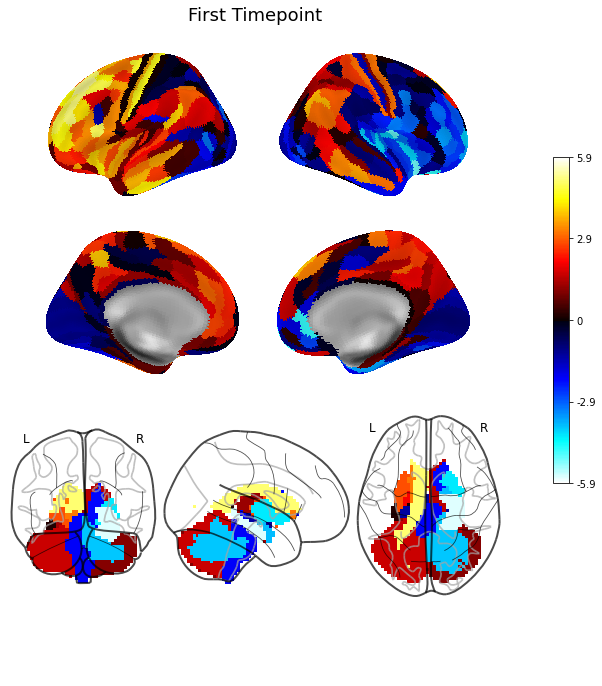

In [7]:
plot({'concat': original_surf,
      'sub': original_sub},
     threshold=.0001, title='First Timepoint')

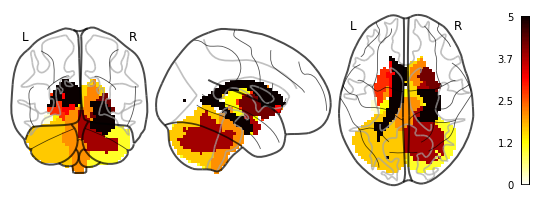

In [8]:
plot(original_sub, vol_plot_type='glass', threshold=.0001)

Visualize which subcortical rois we chose

/home/sage/anaconda3/envs/bpt/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


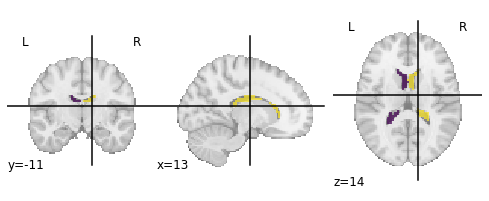

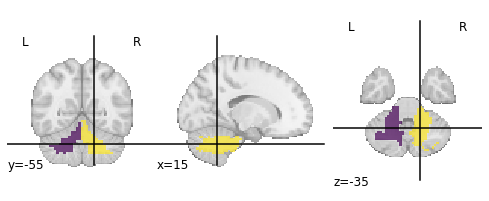

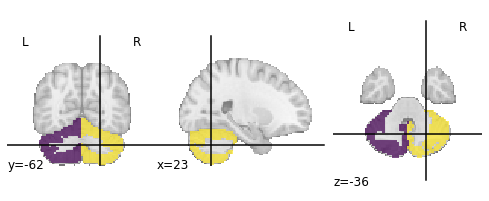

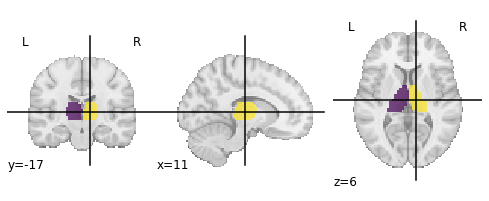

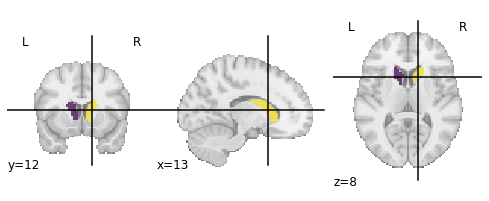

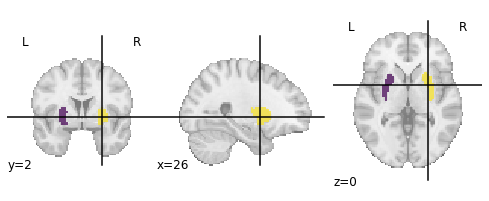

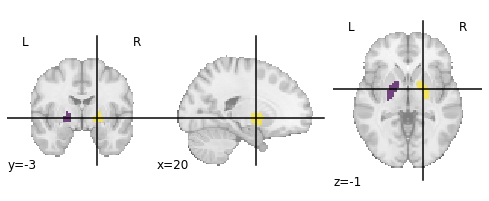

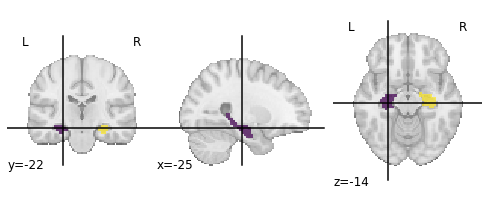

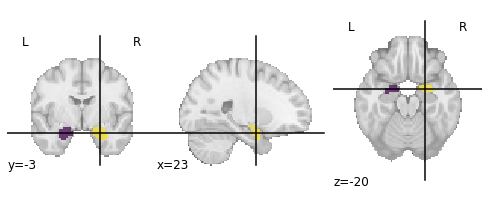

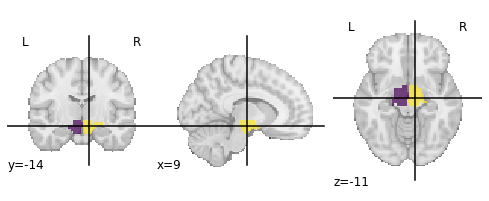

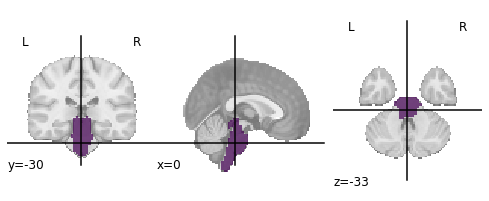

In [9]:
def show_just(rois):
    
    # Load aseg parcel info - this time using the MNI152NLin2009cAsym space
    parc_loc = os.path.join(fmri_func_dr,
                            f'sub-{subj}_task-moviewatching_space-MNI152NLin2009cAsym_desc-aseg_dseg.nii.gz')
    parc = load(parc_loc)

    parc[~np.isin(parc, rois)] = 0
    parc_nii = nib.Nifti1Image(parc, nib.load(parc_loc).affine)

    plot(parc_nii)

show_just([4, 43]), show_just([7, 46])
show_just([8, 47]), show_just([10, 49]),
show_just([11, 50]), show_just([12, 51]),
show_just([13, 52]), show_just([17, 53]),
show_just([18, 54]), show_just([28, 60])
show_just([16])